In [8]:
# Import libraries
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
import numpy as np

!pip install librosa
import librosa

!pip install opendatasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 27.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.8-py3-none-any.whl size=111967 sha256=439896fb9fcdcff8d5c4c31e33d61c928c26b59a4a419b176d257b7efa021c71
  Stored in directory: /scratch/5845407.1.academic-gpu/pip-ephem-wheel-cache-1c94_chu/wheels/b3/86/2d/2df535a84838c858ca91a03805f9c3131573c8e777fd907689
Successfully built kaggle
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
cuda


In [10]:
from torch.utils.data import DataLoader
from dataset import download_datasets, SpeechEmotionDataset, get_dataset_info



# Specify the directory you want the datasets to be contained in
!mkdir -p datasets
dataset_dir = "./datasets"


# Only needed to run this code once
'''
# Download a single dataset
download_datasets(dataset_dir, dname="emodb")

# Download the rest of the datasets available
download_datasets(dataset_dir)
'''

# Acquire info on datasets (those that have functions to get data for)
df = get_dataset_info(dataset_dir)

# Make into a Dataset object that a pytorch optimizer can use
# Can optionally specify a sampling rate for all audio files to be in
trainset = SpeechEmotionDataset(df, fs=16000)

# Check it works
trainset = SpeechEmotionDataset(df, fs=16000)
dataiter = iter(trainset)
data, label = next(dataiter)
print(data)
print(label)
print(df) # columns are: filename, speaker_n, intensity, emotion, version, language, database 

# Put into a dataloader
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=1)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jaylinlily
Your Kaggle Key: ········


100%|██████████| 38.0M/38.0M [00:00<00:00, 69.9MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jaylinlily
Your Kaggle Key: ········


100%|██████████| 428M/428M [00:05<00:00, 81.7MB/s] 



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jaylinlily
Your Kaggle Key: ········


100%|██████████| 451M/451M [00:07<00:00, 65.4MB/s] 



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jaylinlily
Your Kaggle Key: ········


100%|██████████| 429M/429M [00:03<00:00, 114MB/s]  



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jaylinlily
Your Kaggle Key: ········


100%|██████████| 215M/215M [00:03<00:00, 65.4MB/s] 



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jaylinlily
Your Kaggle Key: ········


100%|██████████| 829M/829M [00:12<00:00, 71.1MB/s] 



tensor([ 9.1553e-05, -3.0518e-04, -7.9346e-04,  ..., -1.2207e-03,
        -1.4343e-03, -1.5259e-03])
anxiety
                                                filename speaker_n intensity  \
0      ./datasets/berlin-database-of-emotional-speech...        16        NA   
1      ./datasets/berlin-database-of-emotional-speech...        10        NA   
2      ./datasets/berlin-database-of-emotional-speech...        16        NA   
3      ./datasets/berlin-database-of-emotional-speech...        16        NA   
4      ./datasets/berlin-database-of-emotional-speech...        14        NA   
...                                                  ...       ...       ...   
15692  ./datasets/shemo-persian-speech-emotion-detect...        56        NA   
15693  ./datasets/shemo-persian-speech-emotion-detect...        12        NA   
15694  ./datasets/shemo-persian-speech-emotion-detect...        12        NA   
15695  ./datasets/shemo-persian-speech-emotion-detect...        04        NA   
15696  ./d

In [11]:
'''
Feature Extraction
1) Wav2vec2 model
'''
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H # can choose another wav2vec2 model
print("Sample rate: ", bundle.sample_rate)
print("Labels: ", bundle.get_labels())
model = bundle.get_model().to(device)

# Example audio
SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
IPython.display.Audio(SPEECH_FILE)
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
# Resample example audio if its sample rate doesn't match the pipeline's sample rate
if sample_rate != bundle.sample_rate:
    print("Audio vs Bundle sample rate: ", sample_rate, bundle.sample_rate)
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    
# Extract features
with torch.inference_mode():
    features, _ = model.extract_features(waveform)
    

Sample rate:  16000
Labels:  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [14]:
'''
Feature Extraction
2) Hand-crafted features: ZCR, RMSE, MFCC
'''
X, sample_rate = librosa.load('./datasets/berlin-database-of-emotional-speech-emodb/wav/03a01Fa.wav')
mfccs = np.mean(librosa.feature.mfcc(y=X, n_mfcc=25,), axis = 0) # calculating mean?
rms = librosa.feature.rms(y=X) # root mean square value for each frame of audio sample
zcr = librosa.feature.zero_crossing_rate(y=X) # zero crossing rate of audio time series

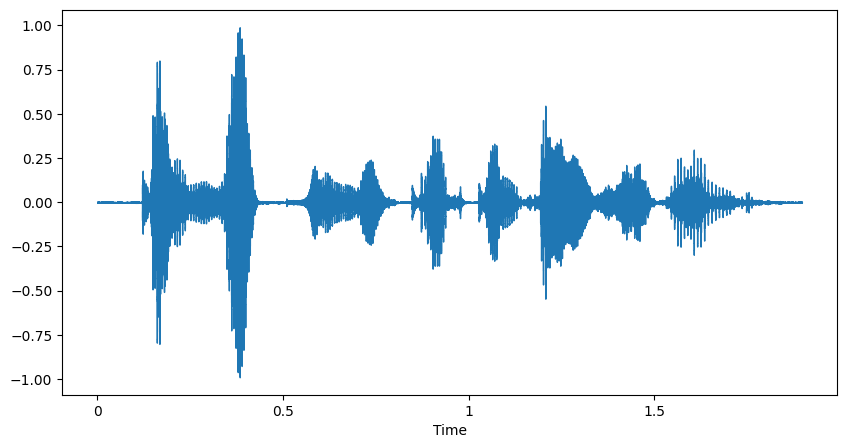

In [15]:
# Let's visualize what we are doing!
# some of this code taken from https://github.com/MiteshPuthran/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
librosa.display.waveshow(X, sr=sample_rate)

In [18]:
# putting features into dataframes
import os

# needs "/" at end of filepath
data_filepath = "./datasets/berlin-database-of-emotional-speech-emodb/wav/"

database_name = "berlin-database-of-emotional-speech-emodb"
filenames_list = os.listdir(data_filepath) # filenames without full filepath
full_filenames_list = [data_filepath + filename for filename in filenames_list] # adding full filepath

In [19]:
# extract features of all audio files into a dataframe
import pandas as pd

features_df = pd.DataFrame(columns=['filename', 'mfccs', 'rms', 'zcr', 'emotion'])

# works for a single folder of audio files at once, all from the same dataset
for i, filename in enumerate(full_filenames_list):
    X, sample_rate = librosa.load(filename) # load waveform
    mfccs = np.mean(librosa.feature.mfcc(y=X, n_mfcc=25,), axis = 0) # calculate feature values
    rms = librosa.feature.rms(y=X)
    zcr = librosa.feature.zero_crossing_rate(y=X)
    features_df.at[i, 'mfccs'] = mfccs # save X features to dataframe
    features_df.at[i, 'rms'] = np.array(rms)
    features_df.at[i, 'zcr'] = np.array(zcr)
    
    row_index = df.loc[df['filename'] == filename].index[0] # finding the correct emotion for the filename
    features_df.at[i, 'emotion'] = df.at[row_index,'emotion'] # selects correct emotion from Noah's df
    
    split_name = filename.split('/') # get the correct filename
    features_df.at[i, 'filename'] = split_name[-1]
    
    #features_df.at[i,'emotion'] = df.loc['im','emotion']

#features_df = pd.concat([features_df, labels_df], axis=1)
print(features_df)

        filename                                              mfccs  \
0    16b01Aa.wav  [-14.780913, -14.325403, -13.693046, -13.05944...   
1    10b09Lb.wav  [-11.474661, -9.416283, -9.904519, -10.41776, ...   
2    16a05La.wav  [-14.149419, -11.2464285, -8.616501, -8.848203...   
3    16a02Nb.wav  [-12.976416, -12.096367, -8.972505, -7.3359556...   
4    14a02La.wav  [-11.86352, -10.168923, -10.589436, -11.380253...   
..           ...                                                ...   
530  08b10La.wav  [-10.3835335, -7.8500013, -6.9223866, -3.99789...   
531  16b03La.wav  [-15.408475, -12.201984, -11.546626, -11.74224...   
532  12b02Fb.wav  [-18.119234, -7.136423, -3.4530761, -4.165739,...   
533  13a05Ea.wav  [-7.609747, -6.5680695, -5.8979325, -6.145536,...   
534  13b09Wa.wav  [-16.652184, -16.380753, -15.454414, -12.80498...   

                                                   rms  \
0    [[0.0009390469, 0.001251537, 0.0014829956, 0.0...   
1    [[0.002468433, 0.002628517

In [33]:
# Now let's shuffle these boiz
from sklearn.model_selection import train_test_split

train, test = train_test_split(features_df, test_size=0.2, random_state=42, shuffle=True)


        filename                                              mfccs  \
284  03b02Aa.wav  [-14.079135, -12.323546, -11.474248, -9.09061,...   
347  12b03Ta.wav  [-9.775077, -7.466317, -6.8036146, -6.629843, ...   
440  13b02Nb.wav  [-9.2703085, -7.783403, -7.8381305, -6.5176373...   
421  14b10Lb.wav  [-14.253737, -13.220742, -10.550857, -8.464507...   
149  11b01Fc.wav  [-16.935766, -15.290205, -14.847381, -13.48610...   
..           ...                                                ...   
71   13a04Wc.wav  [-17.091368, -14.799666, -13.599548, -13.60320...   
106  16b03Ad.wav  [-15.301025, -13.604454, -14.486785, -15.71678...   
270  09b03Nb.wav  [-9.124634, -8.144319, -8.019176, -7.788812, -...   
435  14a04Tc.wav  [-10.157893, -7.504263, -6.495217, -6.782695, ...   
102  08b03Fe.wav  [-14.783207, -14.364163, -13.856281, -13.53113...   

                                                   rms  \
284  [[0.0013622892, 0.0019244545, 0.0062129647, 0....   
347  [[0.007245047, 0.011252102

In [20]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

from torchvision import datasets
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [21]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [22]:
"""
Building Network architecture based on the paper:
Human–Computer Interaction with a Real-Time Speech
Emotion Recognition with Ensembling Techniques 1D
Convolution Neural Network and Attention
(https://doi.org/10.3390/s23031386)

We are taking the output of CNN as the input of LSTM.
CNN captures local patterns in audio features, and
LSTM learns temporal dependencies before making final prediction. This supports
robust sequence prediction.
"""

import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        # bn = batch normalization
        ####################
        # Convolution blocks: 1dconv, batch norm, ReLU, max pooling
        # Conv block 1
        self.conv1 = nn.Conv1d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm1d(8)

        # Conv block 2
        self.conv2 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm1d(16)

        # Conv block 3
        self.conv3 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm1d(32)

        # Conv block 4
        self.conv4 = nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm1d(64)

        # Conv block 5
        self.conv5 = nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn5 = nn.BatchNorm1d(128)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size = 2, stride = 2)
        ####################

        ####################
        # LSTM + attention block
        self.lstm1 = nn.LSTM(input_size = 128, hidden_size = 64, num_layers = 1, bias = True)

        self.attention = nn.Linear(64, 1)
        self.softmax = nn.Softmax(dim=1)

        self.lstm2 = nn.LSTM(input_size = 64, hidden_size = 64, num_layers = 1, bias = True)
        ####################


        self.fc1 = nn.Linear(64, 32) # May need to increase 32 to capture more complex data (?)
        self.bn6 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)


    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.pool(x)

        # LSTM + attention block
        # output_tensor, hiddenstate = self.lstm()
        lstm1_out, _ = self.lstm1(x)

        attention_weights = self.softmax(self.attention(lstm1_out))
        context = torch.sum(attention_weights * lstm1_out, dim=1)

        lstm2_out, _ = self.lstm2(context.unsqueeze(-1))

        # fully connected layers and softmax
        x = self.fc1(lstm2_out.squeeze(1))
        x = self.bn6(x)
        x = self.fc2(x)

        # Softmax for prediction
        # F.softmax is used instead of self.softmax because it is not associated
        # with any parameters
        x = F.softmax(x, dim=1)

        return x

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net =  CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer =  optim.Adam(net.parameters(), lr=1e-4)

In [36]:
# Training loop
root_dir = './runs'
os.makedirs(root_dir, exist_ok=True)

def train_on_features(net, optimizer, device, trainloader, critrerion, epochs=1):
    if torch.cuda.is_available():
        net.cuda()
    net.train()

    loss_min = float('inf')
    for epoch in range(epochs):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            pred = net(inputs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
            if loss < loss_min:
                torch.save(net.state_dict(), os.path.join(root_dir, "best_ser_model.pth"))


    print('Finished Training')
    return net

net = train_on_features(net, optimizer, device, trainloader, criterion)

AttributeError: 'tuple' object has no attribute 'to'

In [37]:
#net = train_on_features(net, optimizer, device, trainloader, criterion)
# trainloader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)
# for i, data in enumerate(trainloader):
#     print(data)
print(trainset[0])

(tensor([ 9.1553e-05, -3.0518e-04, -7.9346e-04,  ..., -1.2207e-03,
        -1.4343e-03, -1.5259e-03]), 'anxiety')
